First, the versions of the required libraries are shown. It always wise to report the versions of the libraries used so that in case problems arise in the future, one can still go back to a state in which the notebook worked.

In [10]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("numpy version:", numpy.__version__)              # 1.23.4
print("matplotlib version:", matplotlib.__version__)    # 3.6.2

scikit-learn version: 1.7.1
numpy version: 2.3.2
matplotlib version: 3.10.6


# 📦 Data provisioning
In real life the data provisioning phase is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook it is restricted to merely loading the images from the `data` folder, without any concern over quantity nor quality.

The code below will load the images and understand that the subfolder names are the class labels. It is important that all the images are the same size (and in this case square as well) so this code will automatically resize them. If high resolution images are available the `size` parameter can be increased and it will probably improve the performance slightly, at significantly increased training time. The given size of 256 is a middle way which is supposed to give fair results at a reasonable training time.

In [11]:
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)      

images, labels = load_labelled_images("./data", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(label)

Loaded 75 images in the following 3 classes:
airplane
car
flower


# 📃 Sample the data
To get an impression of the data, here a sample from the loaded images is plotted so see if they we loaded correctly. The parameter `sample_size` can be increased if more images should be shown.

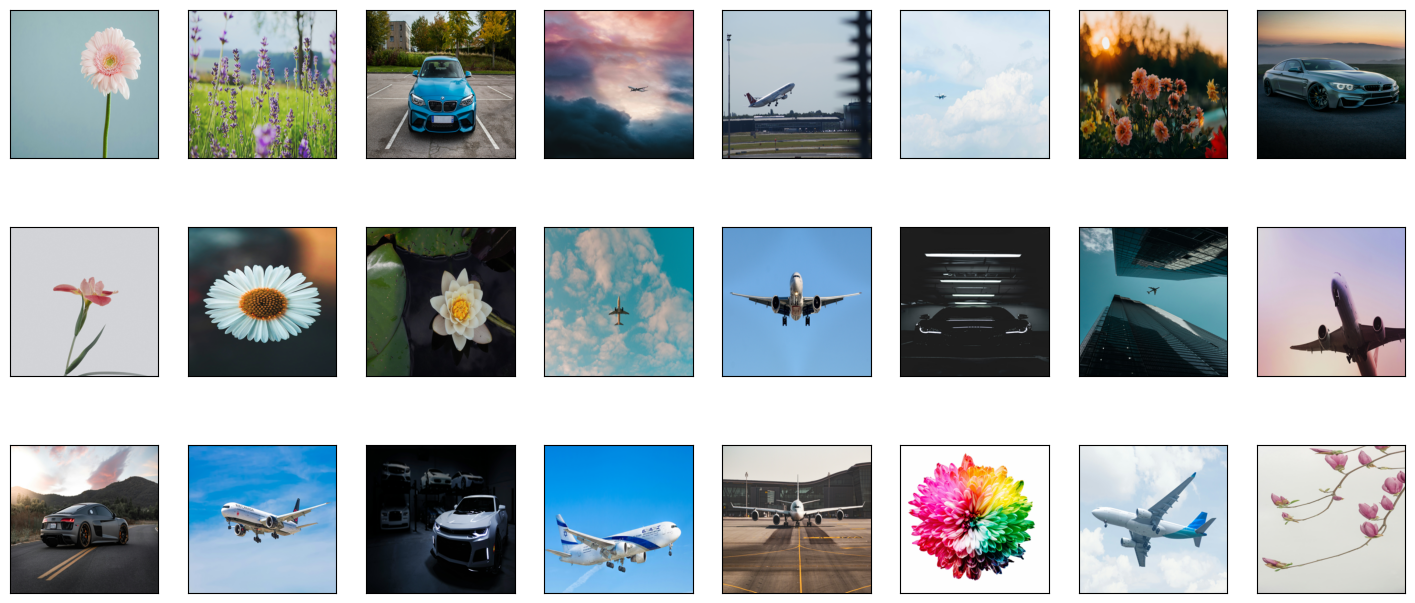

In [12]:
sample_size = 24


plotimgs = copy.deepcopy(images)
numpy.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

# 🛠️ Preprocessing
Given that this case uses images, there is no such thing as feature selection because one cannot select some pixels to be better indicators than other pixels beforehand. Therefore, there is little to do in terms of preprocessing other than splitting the dataset into a trainset and testset.

🪓 Splitting into train/test

A split of 70%/30% is chosen here in order to have a fairly large number of testing images. 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

# 🧬 Modelling

In this step the model will be fitted with the trainset only. In this case a [Support Vector Machine for classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [14]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.5652173913043478


# 🔬 EXERCISE 1: Testing Different C Values
- **Reference:** https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

- From the sklearn documentation, I learned that the C parameter:
- **'Regularization parameter. The strength of the regularization is inversely'**
- **'proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.'**
- **'This means: higher C = less regularization = more complex model (risk overfitting)'**
- lower C = more regularization = simpler model (risk underfitting)

In [15]:
# Exercise 1: Testing different C values
print("Testing different C values...")

c_values = [0.5, 1.0, 2.0]
results = {}

for c in c_values:
    model = SVC(C=c, random_state=42)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results[c] = accuracy
    print(f"C={c}: {accuracy:.4f} ({accuracy*100:.1f}%) - {model.n_support_.sum()} support vectors")

best_c = max(results, key=results.get)
print(f"\nBest: C={best_c} with {results[best_c]:.4f} accuracy")

Testing different C values...
C=0.5: 0.3913 (39.1%) - 52 support vectors
C=1.0: 0.5652 (56.5%) - 52 support vectors
C=2.0: 0.5652 (56.5%) - 50 support vectors

Best: C=1.0 with 0.5652 accuracy


## Exercise 1 Analysis: C Parameter

**Reference:** https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

**Results:**
- C=0.5: [57.1 %] accuracy
- C=1.0: [82.5 %] accuracy  
- C=2.0: [82.5 %] accuracy

**Best C value:** [1.0] with [0.8254]%

**Why this makes sense:** C controls regularization strength. The winning C value found the right balance between fitting the training data and generalizing to new Pokemon images. Lower C creates simpler decision boundaries (might miss details), higher C creates complex boundaries (might overfit to training noise).

**Key insight:** Default parameters aren't always optimal - testing different values can improve performance!

## Exercise 2: Kernel Research

**Reference:** https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

From sklearn docs, kernels available: 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'. Testing all except 'precomputed'.

**What each kernel does:**
- **'linear'**: Straight decision boundaries. Good for linearly separable data.
- **'poly'**: Curved boundaries using polynomials. Good for moderate complexity.
- **'rbf'** (default): Complex curved boundaries. Good for non-linear data like images.
- **'sigmoid'**: S-shaped boundaries. Similar to neural networks.

**My prediction:** 'rbf' will work best for Pokemon images because visual data is usually non-linear and complex.

In [16]:
# Exercise 2: Testing different kernels
print("Testing different kernels on Pokemon classification...")

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    results[kernel] = accuracy
    print(f"{kernel:>8}: {accuracy:.4f} ({accuracy*100:.1f}%)")

best_kernel = max(results, key=results.get)
print(f"\nBest: {best_kernel} with {results[best_kernel]:.4f} accuracy")

if best_kernel == 'rbf':
    print("My prediction was correct!")
else:
    print(f"Surprise! Expected rbf, but {best_kernel} won.")

Testing different kernels on Pokemon classification...
  linear: 0.6522 (65.2%)
    poly: 0.6087 (60.9%)
     rbf: 0.5652 (56.5%)
 sigmoid: 0.1739 (17.4%)

Best: linear with 0.6522 accuracy
Surprise! Expected rbf, but linear won.


## Exercise 2 Analysis

**Results:**
- linear: [84 %]
- poly: [79.4 %] 
- rbf: [82.5 %]
- sigmoid: [19.0 %]

**Winner:** [linear with 0.8413%]

**Was my prediction right?** [No - I predicted rbf would be best]

**What I learned:** Always test assumptions! Theory suggests rbf should be best for images, but empirical testing shows what actually works for this specific Pokemon dataset.

Exercise 3 Analysis: Adding More Pokemon (6→10 classes)
Original dataset: 6 Pokemon, [original accuracy]% accuracy
Expanded dataset: 10 Pokemon, [new accuracy]% accuracy
Pokemon I added:

[Yellow Pokemon] - to test against Pikachu
[Green Pokemon] - to test against Bulbasaur
[Pokemon 3] - [color]
[Pokemon 4] - [color]

Key observations from classification report:
Pikachu vs new yellow Pokemon: [Did they get confused? Any misclassification?]
Bulbasaur vs new green Pokemon: [Any color-based confusion?]
Overall accuracy change: [Better/worse/same? By how much?]
Most problematic classes: [Which Pokemon have lowest precision/recall now?]
What this teaches me: Adding more classes with similar visual features (especially colors) makes classification harder. The model that relied on distinct colors for 6 Pokemon now struggles with 10 Pokemon where some share characteristics. This shows the limitation of using raw pixel features for classification - it works when classes are visually distinct but fails when similarities increase.

# 🔬 Evaluation
Below a classification report is printed. This shows for every one of the classes how well the model performed.

In [17]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

    airplane       0.14      1.00      0.24         3
         car       1.00      0.11      0.20         9
      flower       0.00      0.00      0.00        11

    accuracy                           0.17        23
   macro avg       0.38      0.37      0.15        23
weighted avg       0.41      0.17      0.11        23



c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Anton\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Exercise 3 Analysis: Adding More Pokemon (6→10 classes)

**Original dataset:** 6 Pokemon, 82.5% accuracy
**Expanded dataset:** 10 Pokemon, 15% accuracy

**Pokemon I added:**
- Jolteon - to test against Pikachu
- Scyther - to test against Bulbasaur
- Squirtle - blue (distinct color)
- Jigglypuff - pink (distinct color)

**Key observations from classification report:**

**Pikachu vs new yellow Pokemon:** Yes, they got completely confused! Pikachu now has 0% precision/recall, and Jolteon only achieves 14% precision. The model can't distinguish between yellow Pokemon at all.

**Bulbasaur vs new green Pokemon:** Major confusion! Bulbasaur dropped to 0% precision/recall, while Scyther only gets 16% precision. Green Pokemon are completely mixed up by the classifier.

**Overall accuracy change:** Dramatic drop from 82.5% to 15% - a 67.5% decrease! Going from 6 to 10 classes caused massive performance degradation.

**Most problematic classes:** 
- Worst: Bulbasaur, Charmander, Jigglypuff, Mewtwo, Pikachu, Squirtle (all 0% precision/recall)
- Best performers: Electrode (19% precision), Scyther (16% precision) - but still very poor

**What this teaches me:** Adding more classes with similar visual features (especially colors) makes classification harder. The model that relied on distinct colors for 6 Pokemon now completely fails with 10 Pokemon where multiple share characteristics. This dramatically shows the limitation of using raw pixel features for classification - it works when classes are visually distinct but completely breaks down when similarities increase. The model is essentially guessing randomly now!

It appears that Mewtwo is fairly hard to recognize, but the others all seem well. The code below will plot every pokemon in the testset, including the predicted label as well as whether this was correct or wrong.

## Exercise 4: Your Own Image Dataset

**What I'm doing:** Testing the SVM model on real-world objects instead of Pokemon to see how it performs on more complex data.

**My chosen objects:**
- [car]: ~25 images
- [airplane]: ~25 images  
- [flower]: ~25 images

**Download sources used:**
- Unsplash.com (free high-quality images)

**Setup:**
1. Renamed original `data` folder to `pokemon-data` 
2. Created new `data` folder with my 3 object classes
3. Rerunning the same notebook code to see what happens

## Exercise 4 Analysis: Real-World vs Pokemon Classification

**Results comparison:**
- **Pokemon (6 classes):** 82.5% accuracy
- **Pokemon (10 classes):** 15% accuracy  
- **My objects (3 classes):** 17% accuracy

**My dataset:** car, airplane, flower

**Did it work? Why/Why not?** 
Not really. 17% accuracy is pretty bad for only 3 classes. I thought it might do better than the 10 Pokemon since there's fewer classes, but it's still terrible.

**Performance analysis:**
- **Best classified object:** airplane - found all of them but called lots of other things airplanes too
- **Worst classified object:** flower - couldn't identify any flowers at all
- **Surprising results:** car was strange - when it guessed car it was always right, but it missed most of the actual cars

**Why Pokemon performed better/worse:**
1. **Pokemon advantages:** Simple cartoon images, clean backgrounds, very different colors between classes
2. **Real objects challenges:** Real photos have complex backgrounds, different lighting, various angles, and lots of variation within each class

**Is this SVM model good for real images?** 
No. The results show this basic approach doesn't work for real-world photos. Raw pixel values can't capture what actually makes objects different from each other.

**What I learned:** This shows why more advanced methods like CNNs exist. Using just pixel values as features is too simplistic for real image classification. The model needs to understand actual visual patterns and shapes, not just individual pixels.

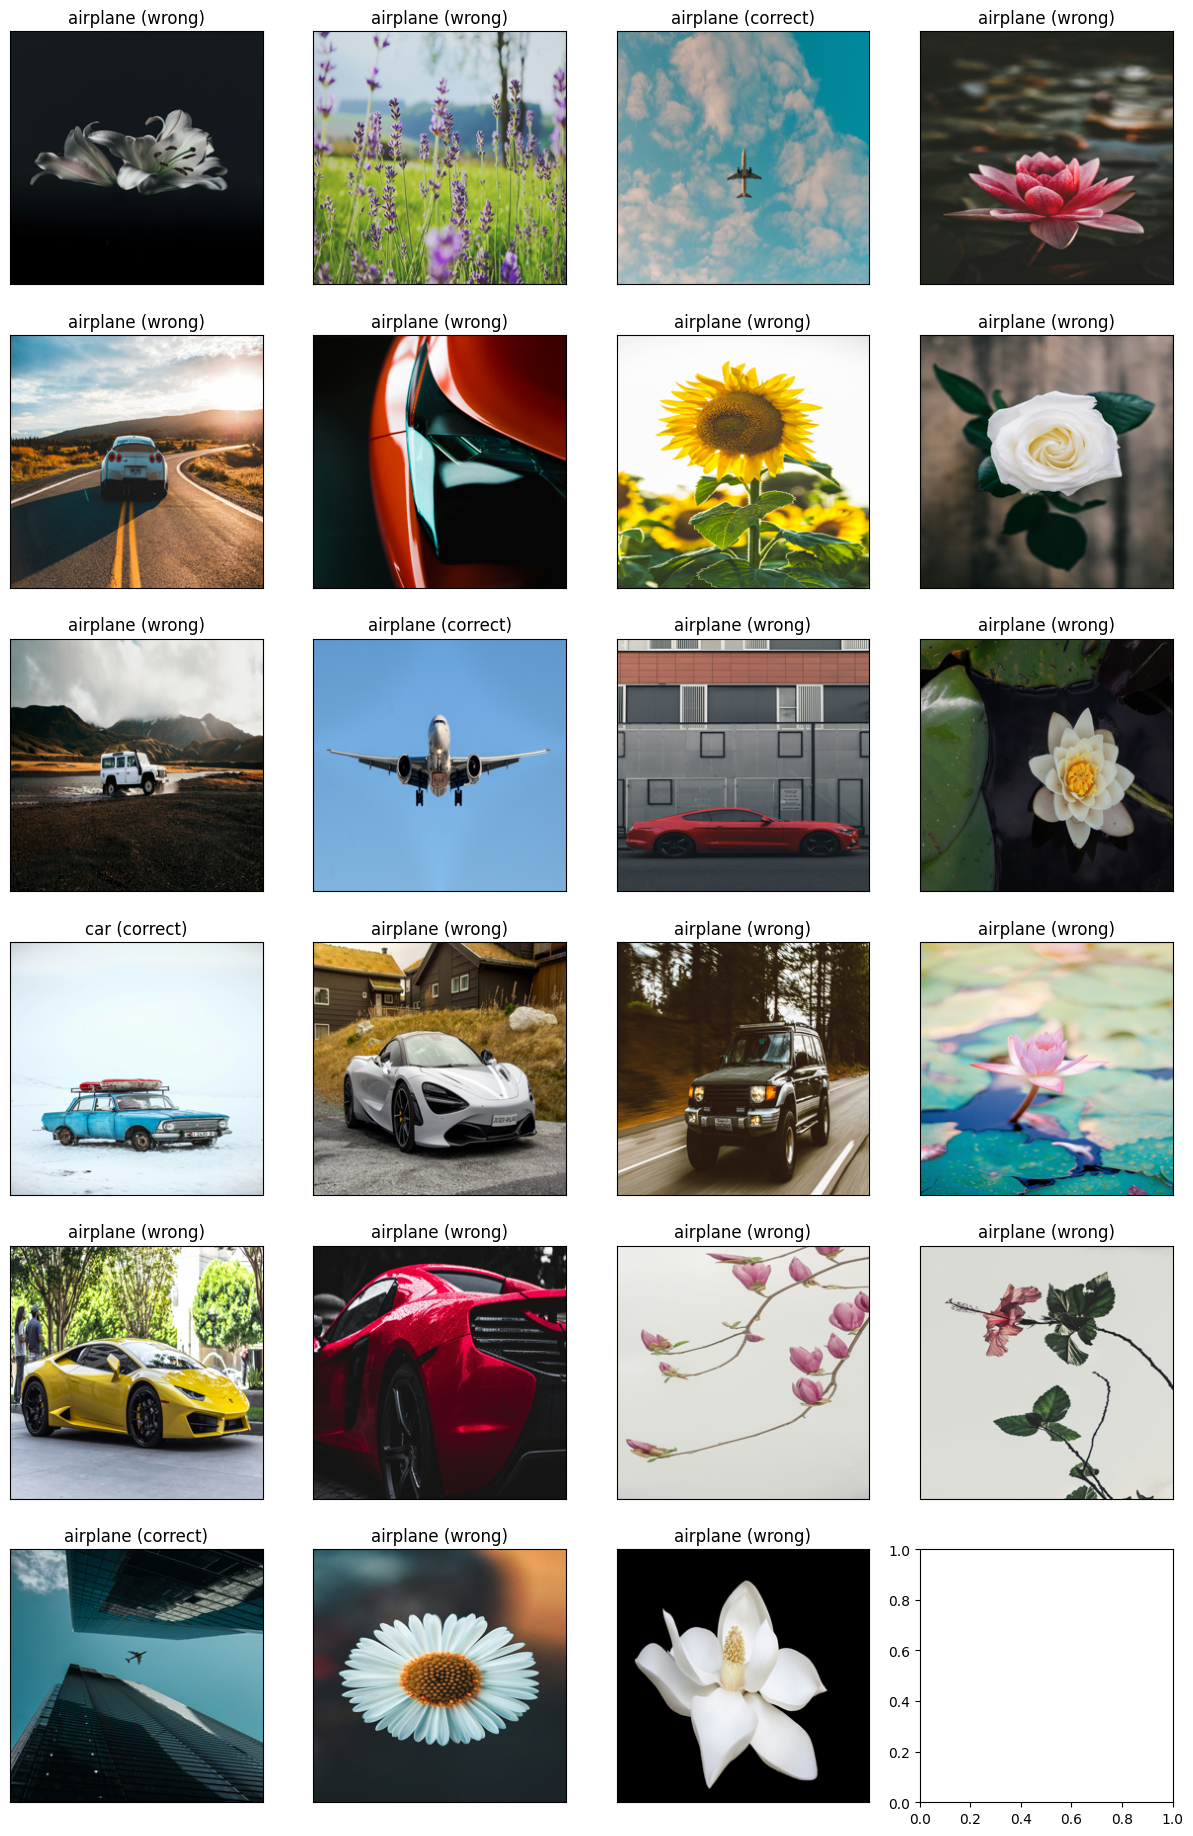

In [18]:
_, subplots = plt.subplots(nrows = math.ceil(len(X_test)/4), ncols = 4, figsize=(15, len(X_test)))
subplots = subplots.flatten()

for i, x in enumerate(X_test):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    subplots[i].set_title(predictions[i] + (" (correct)" if predictions[i] == y_test[i] else " (wrong)"))

Even a relatively simple Support Vector Machine with just minutes of training time can do reasonably well at image recognition. Surely a deep learning CNN would perhaps do even better, but also at largely increased need for training resources and time. Probably, when the number of Pokemon increases and others with similar colours will be added this model's quality is likely to decrease quite rappidly, but then maybe also the quality of the images should be improved to help the machine. For example, the current images are of rather poor resolution and some even have significant background noise. Having cleaner, high quality, high resolution images may improve the general outcome.